## Kaggle https://www.kaggle.com/datasets/andrewmvd/animal-faces

In [1]:
!pip install kaggle

In [2]:
import os
import json

kaggle_json_path = 'kaggle.json'

try :
    # Read the kaggle.json file
    with open(kaggle_json_path) as f:
       kaggle_config = json.load(f)

    userkaggle       = kaggle_config['username']
    passkaggle       = kaggle_config['key']
    os.environ['KAGGLE_USERNAME'] = userkaggle
    os.environ['KAGGLE_KEY'] = passkaggle
    print("KAGGLE_USERNAME and KAGGLE_KEY are set.")
except :
    print("KAGGLE_USERNAME or KAGGLE_KEY is not set.")

KAGGLE_USERNAME and KAGGLE_KEY are set.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils 

In [4]:
import zipfile
import os
from IPython.display import clear_output

dataset_name = 'animal-faces'
zip_path = f'{dataset_name}.zip'

if not os.path.exists(dataset_name):
    !kaggle datasets download -d andrewmvd/animal-faces 
     
if not os.path.exists(dataset_name) and os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_name)



clear_output()


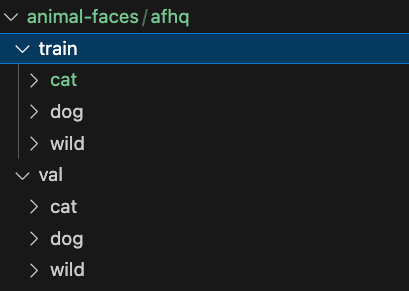

In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the path to the directory containing the images
path = './animal-faces/afhq/train'

# Get a list of all image files with the .jpg extension
image_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.jpg'):
            image_files.append(os.path.join(root, file))

print('Number of images found:', len(image_files))

Number of images found: 14630


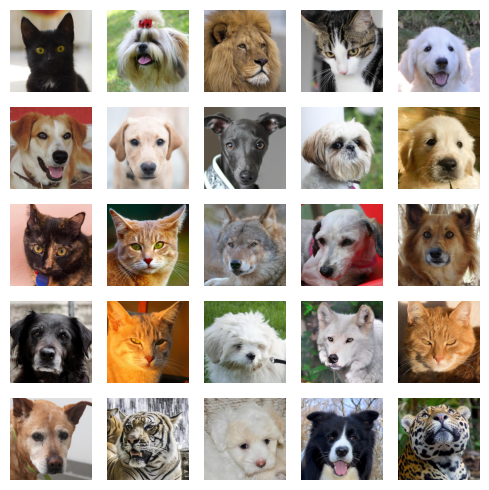

In [6]:
import random
# Randomly sample 8x8 images
sample_images = random.sample(image_files, 25)

# Display the sample grid image with 8x8 layout
fig, axs = plt.subplots(5, 5, figsize=(5, 5))
for i, ax in enumerate(axs.flatten()):
    img = mpimg.imread(sample_images[i])
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Dataloaders without transforms

In [7]:
import torchvision.transforms as transforms

#

In [8]:


train_path = 'animal-faces/afhq/train'

dataset    = ImageFolder(root=train_path , transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=20, shuffle=True , num_workers=2)

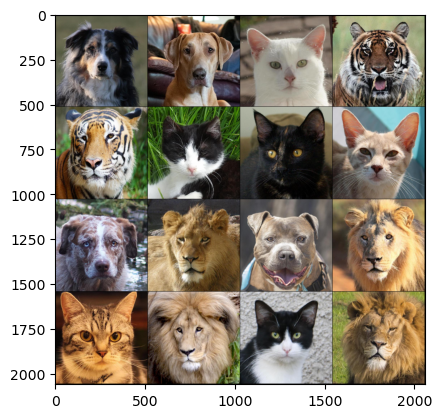

In [9]:
# %%
def imshow(image_torch): 
    # flip image channels to RGB
    image_torch = image_torch.numpy().transpose((1, 2, 0)) 
    plt.figure() 
    plt.imshow(image_torch) 
 
X_train, y_train = next(iter(dataloader)) 
image_grid = torchvision.utils.make_grid(X_train[:16, :, :, :], scale_each= True, nrow=4) 
imshow(image_grid) 

# Dataloaders with transforms

In [10]:


transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop and resize the image to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image by 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),  # Convert the image to a tensor
   # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image with mean and standard deviation
])




train_path = 'animal-faces/afhq/train'

dataset    = ImageFolder(root=train_path , transform=transform)
dataloader = DataLoader(dataset, batch_size=20, shuffle=True , num_workers=1)

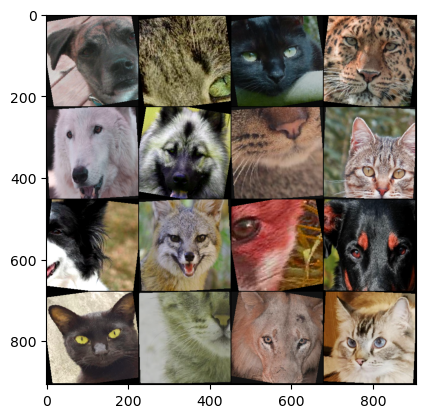

In [11]:
# %%
def imshow(image_torch): 
    # flip image channels to RGB
    image_torch = image_torch.numpy().transpose((1, 2, 0)) 
    plt.figure() 
    plt.imshow(image_torch) 
 
X_train, y_train = next(iter(dataloader)) 
image_grid = torchvision.utils.make_grid(X_train[:16, :, :, :], scale_each= True, nrow=4) 
imshow(image_grid) 

In [12]:


transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop and resize the image to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Randomly rotate the image by 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image with mean and standard deviation
])




train_path = 'animal-faces/afhq/train'
test_path  = 'animal-faces/afhq/val'

train_dataset    = ImageFolder(root=train_path , transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True , num_workers=2)

test_dataset    = ImageFolder(root=test_path , transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True , num_workers=2)

# find the number of classes
num_classes = len(train_dataset.classes)
print('Number of classes:', num_classes)

Number of classes: 3


In [13]:
import torch
import torch.nn as nn
import torchvision.models as models
import warnings
warnings.filterwarnings("ignore")


class TransferLearningModel(nn.Module):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()

        self.resnet = models.resnet50(pretrained=True)
        
        for param in self.resnet.parameters():
            param.requires_grad = False

        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


model = TransferLearningModel(num_classes =3)

model

TransferLearningModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [14]:
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
# Set tqdm to display all progress bars at once


def train(model, train_dataloader, criterion, optimizer, device):
    # Set the model to training mode
    model.train()

    # Initialize variables for tracking loss and accuracy
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Create a tqdm progress bar
    progress_bar = tqdm(train_dataloader, desc="Training")

    # Iterate over the training dataloader with tqdm for progress tracking
    for images, labels in progress_bar:
        # Move the data to the GPU
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item() * images.size(0)

        # Calculate the predicted labels
        _, predicted = torch.max(outputs.data, 1)

        # Update the total and correct predictions
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Check if CUDA is available
        if torch.cuda.is_available():
            # Get the current GPU memory usage
            allocated_memory = torch.cuda.memory_allocated()
            cached_memory = torch.cuda.memory_cached()
            progress_bar.set_postfix({'Loss': loss.item(), 'Accuracy': (correct_predictions / total_predictions) * 100,'Allocated Memory (MB)': allocated_memory / 1e6, 'Cached Memory (MB)': cached_memory / 1e6})
        else:
            print("CUDA is not available.")
            progress_bar.set_postfix({'Loss': loss.item(), 'Accuracy': (correct_predictions / total_predictions) * 100})

        # Update the progress bar description with loss and accuracy
        
    # Calculate the average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_accuracy = correct_predictions / total_predictions

    return epoch_loss, epoch_accuracy


def test(model, test_dataloader, criterion, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables for tracking loss and accuracy
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Create a tqdm progress bar
    progress_bar = tqdm(test_dataloader, desc="Testing")

    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over the test dataloader with tqdm for progress tracking
        for images, labels in progress_bar:
            # Move the data to the GPU
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Update the running loss
            running_loss += loss.item() * images.size(0)

            # Calculate the predicted labels
            _, predicted = torch.max(outputs.data, 1)

            # Update the total and correct predictions
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            # Update the progress bar description with loss and accuracy
            progress_bar.set_postfix({'Loss': loss.item(), 'Accuracy': (correct_predictions / total_predictions) * 100})

    # Calculate the average loss and accuracy for the test set
    test_loss = running_loss / len(test_dataloader.dataset)
    test_accuracy = correct_predictions / total_predictions

    return test_loss, test_accuracy


In [15]:

# Make sure to define or import 'transform' before using it
train_dataset = ImageFolder(root=train_path, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=80, shuffle=True, num_workers=5)

test_dataset = ImageFolder(root=test_path, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=5)



 #Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the model architecture
model = TransferLearningModel(num_classes=3)  # Ensure TransferLearningModel is defined


# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Move the model to the GPU
model.to(device)

# Set the number of epochs
num_epochs = 15
import matplotlib.pyplot as plt

# Define lists to store the loss and accuracy values
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Train the model
    train_loss, train_accuracy = train(model, train_dataloader, criterion, optimizer, device)

    # Test the model
    test_loss, test_accuracy = test(model, test_dataloader, criterion, device)

    # Append the loss and accuracy values to the lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Print the loss and accuracy for each epoch
    print(f"\nEpoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Check GPU memory usage
    gpu_memory_allocated = torch.cuda.memory_allocated(device)
    gpu_memory_cached = torch.cuda.memory_cached(device)
    print(f"GPU Memory Allocated: {gpu_memory_allocated / 1024**3:.2f} GB, GPU Memory Cached: {gpu_memory_cached / 1024**3:.2f} GB")



Testing: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s, Loss=1.02, Accuracy=69.5] 



Epoch [1/15], Train Loss: 1.0001, Train Accuracy: 0.5651, Test Loss: 0.9208, Test Accuracy: 0.6947
GPU Memory Allocated: 0.10 GB, GPU Memory Cached: 1.43 GB


Testing: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, Loss=0.873, Accuracy=83.1]



Epoch [2/15], Train Loss: 0.8552, Train Accuracy: 0.7802, Test Loss: 0.7945, Test Accuracy: 0.8313
GPU Memory Allocated: 0.10 GB, GPU Memory Cached: 1.43 GB


Testing: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s, Loss=0.735, Accuracy=87.9]



Epoch [3/15], Train Loss: 0.7470, Train Accuracy: 0.8545, Test Loss: 0.6976, Test Accuracy: 0.8787
GPU Memory Allocated: 0.10 GB, GPU Memory Cached: 1.43 GB


Testing: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, Loss=0.639, Accuracy=88.7]



Epoch [4/15], Train Loss: 0.6606, Train Accuracy: 0.8834, Test Loss: 0.6287, Test Accuracy: 0.8867
GPU Memory Allocated: 0.10 GB, GPU Memory Cached: 1.43 GB


Testing: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s, Loss=0.602, Accuracy=90.1]



Epoch [5/15], Train Loss: 0.5953, Train Accuracy: 0.8962, Test Loss: 0.5550, Test Accuracy: 0.9013
GPU Memory Allocated: 0.10 GB, GPU Memory Cached: 1.43 GB


Testing: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s, Loss=0.53, Accuracy=92.3] 



Epoch [6/15], Train Loss: 0.5389, Train Accuracy: 0.9047, Test Loss: 0.5112, Test Accuracy: 0.9227
GPU Memory Allocated: 0.10 GB, GPU Memory Cached: 1.43 GB


Testing: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, Loss=0.448, Accuracy=91]  



Epoch [7/15], Train Loss: 0.4978, Train Accuracy: 0.9082, Test Loss: 0.4810, Test Accuracy: 0.9100
GPU Memory Allocated: 0.10 GB, GPU Memory Cached: 1.43 GB


Testing: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s, Loss=0.485, Accuracy=92.1]



Epoch [8/15], Train Loss: 0.4619, Train Accuracy: 0.9139, Test Loss: 0.4330, Test Accuracy: 0.9213
GPU Memory Allocated: 0.10 GB, GPU Memory Cached: 1.43 GB


Testing: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, Loss=0.396, Accuracy=91.9]



Epoch [9/15], Train Loss: 0.4295, Train Accuracy: 0.9161, Test Loss: 0.4143, Test Accuracy: 0.9193
GPU Memory Allocated: 0.10 GB, GPU Memory Cached: 1.43 GB


Testing: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, Loss=0.461, Accuracy=91.7]



Epoch [10/15], Train Loss: 0.4040, Train Accuracy: 0.9183, Test Loss: 0.3822, Test Accuracy: 0.9173
GPU Memory Allocated: 0.10 GB, GPU Memory Cached: 1.43 GB


Testing: 100%|██████████| 30/30 [00:11<00:00,  2.69it/s, Loss=0.441, Accuracy=92.1]



Epoch [11/15], Train Loss: 0.3799, Train Accuracy: 0.9254, Test Loss: 0.3660, Test Accuracy: 0.9207
GPU Memory Allocated: 0.10 GB, GPU Memory Cached: 1.43 GB


Testing: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, Loss=0.32, Accuracy=92.8] 



Epoch [12/15], Train Loss: 0.3612, Train Accuracy: 0.9228, Test Loss: 0.3517, Test Accuracy: 0.9280
GPU Memory Allocated: 0.10 GB, GPU Memory Cached: 1.43 GB


Testing: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, Loss=0.376, Accuracy=92.7]



Epoch [13/15], Train Loss: 0.3480, Train Accuracy: 0.9254, Test Loss: 0.3388, Test Accuracy: 0.9267
GPU Memory Allocated: 0.10 GB, GPU Memory Cached: 1.43 GB


Testing: 100%|██████████| 30/30 [00:11<00:00,  2.68it/s, Loss=0.286, Accuracy=93.5]



Epoch [14/15], Train Loss: 0.3348, Train Accuracy: 0.9242, Test Loss: 0.3018, Test Accuracy: 0.9347
GPU Memory Allocated: 0.10 GB, GPU Memory Cached: 1.43 GB


Testing: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s, Loss=0.324, Accuracy=92.7]


Epoch [15/15], Train Loss: 0.3231, Train Accuracy: 0.9266, Test Loss: 0.3097, Test Accuracy: 0.9273
GPU Memory Allocated: 0.10 GB, GPU Memory Cached: 1.43 GB


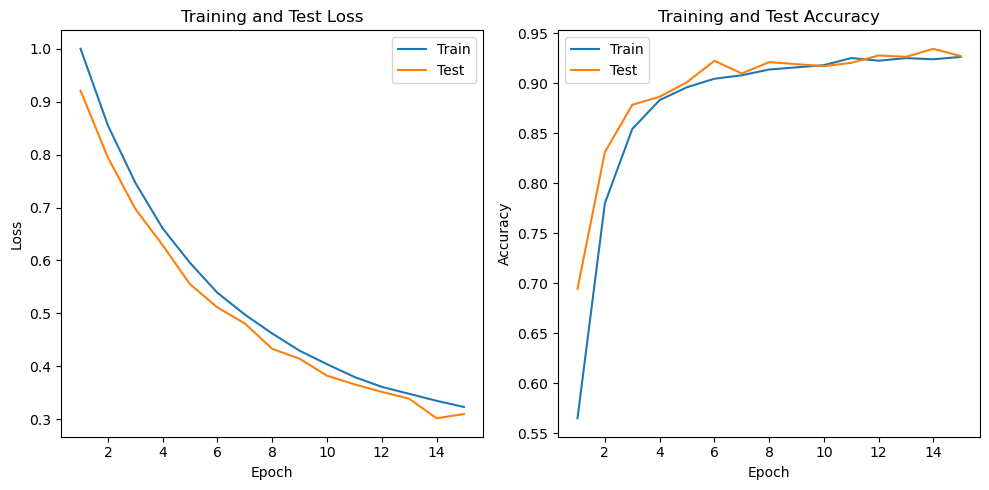

In [16]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.plot(range(1, num_epochs+1), test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


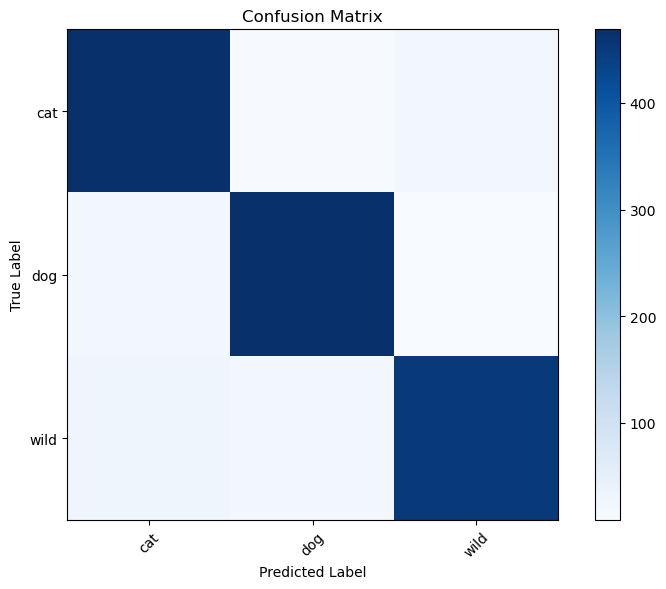

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Set the model to evaluation mode
model.eval()

# Initialize variables for storing true labels and predicted labels
true_labels = []
predicted_labels = []

# Disable gradient calculation
with torch.no_grad():
    # Iterate over the test dataloader
    for images, labels in test_dataloader:
        # Move the data to the GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate the predicted labels
        _, predicted = torch.max(outputs.data, 1)

        # Append the true labels and predicted labels to the lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as an image
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(num_classes), train_dataset.classes, rotation=45)
plt.yticks(np.arange(num_classes), train_dataset.classes)
plt.tight_layout()
plt.show()


In [18]:
cm

array([[469,  11,  20],
       [ 23, 468,   9],
       [ 28,  20, 452]])

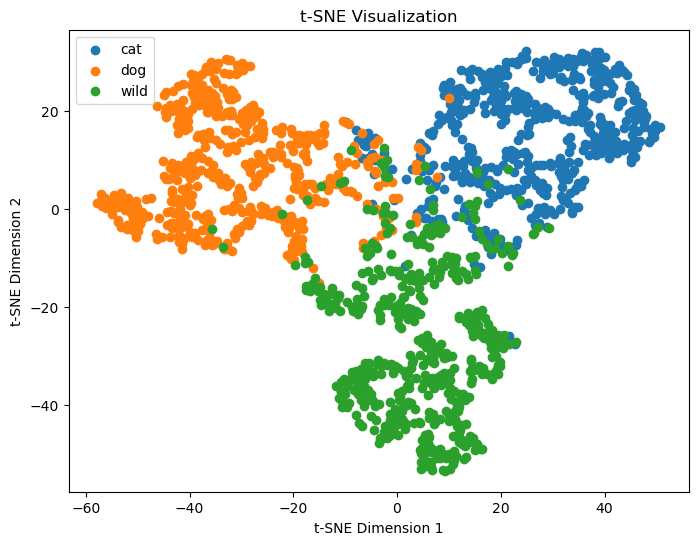

In [24]:
import numpy as np
from sklearn.manifold import TSNE
# plot tsne with test_dataloader
import matplotlib.pyplot as plt
# Set the model to evaluation mode
model.eval()

# Initialize variables for storing features and labels
features = []
labels = []

# Disable gradient calculation
with torch.no_grad():
    # Iterate over the test dataloader
    for images, batch_labels in test_dataloader:
        # Move the data to the GPU
        images = images.to(device)

        # Forward pass to get the features
        outputs = model(images)
        features.extend(outputs.cpu().numpy())
        labels.extend(batch_labels.numpy())

# Convert the features and labels to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Apply t-SNE to reduce the dimensionality of the features
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.scatter(features_tsne[labels == i, 0], features_tsne[labels == i, 1], label=train_dataset.classes[i])
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()
